## DBQAs as diagonalization algorithms

Let us start from some basic imports (and eventually installations).

In [1]:
# if needed, install Qibo uncommenting and executing the following
# !pip install qibo

In [5]:
import logging
        
from copy import deepcopy
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

# Optimization tool: evolutionary algorithm
import cma

import qibo
from qibo import hamiltonians, set_backend

from qibo.models.dbi.double_bracket import (
    # the DBI main class
    DoubleBracketIteration,
    # class which build the generator of the rotations
    DoubleBracketGeneratorType,
)

In [6]:
# The following will help in reducing warnings outputs
class SpecificWarningFilter(logging.Filter):
    def filter(self, record):
        return (
            "Calculating the dense form of a symbolic Hamiltonian"
            not in record.getMessage()
        )

qibo_logger = qibo.config.log
qibo_logger.addFilter(SpecificWarningFilter())

In [7]:
# Set a Qibo backend
# Use Qibojit for better performance when using more than 20 qubits
set_backend("numpy")

[Qibo 0.2.14|INFO|2024-11-26 09:47:38]: Using numpy backend on /CPU:0


Let us add some plotting functions.

In [88]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_loss(losses, steps, labels=[""], title=""):
    """
    Plot loss functions returned by many DBI iterations with two subplots:
    - Left: Iteration vs Loss (original plot)
    - Right: Cumulative steps vs Loss
    """
    # Generate n colors
    colors = ["#ec6c6c", "#dc9d35", "#68da85", "#687fda", "#a768da"]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left subplot: Original plot
    for i, loss in enumerate(losses):
        axs[0].plot(loss, color=colors[i % len(colors)], marker="o", label=labels[i])
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Off-diag norm")
    if len(labels) > 1:
        axs[0].legend()
    
    # Right subplot: Cumulative steps vs Loss
    for i, loss in enumerate(losses):
        # Compute cumulative steps
        cumulative_steps = np.cumsum(steps[i])
        axs[1].plot(cumulative_steps, loss, color=colors[i % len(colors)], marker="o", label=labels[i])
    axs[1].set_xlabel("Time (cumulative s)")
    if len(labels) > 1:
        axs[1].legend()
    
    # Overall title
    if title:
        fig.suptitle(title)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


For the sake of this tutorial notebook, we will consider as input Hamiltonian a 1 dimensional Heisenberg XXZ. It is clearly a problem which can be addressed by using Tensor Network methods, or Bethe ansatze, but it will be used as illustrative example.
Actually, for some of the DBIs we discuss below, a more complex (non integrable) model could be less problematic.

In [89]:
# Some hyper-parameters
nqubits = 5
nsteps = 10

# Let's target the Heisenberg Hamiltonian
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5, dense=True)

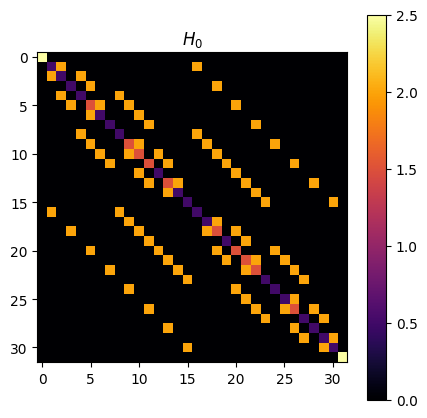

In [90]:
visualize_matrix(h0.matrix, r"$H_0$")

#### Recap of the DBI tools

We target an input hamiltonian $\hat{H}_0$, to which we apply a sequence of rotations:
$$ \hat{H}_{k+1} = e^{s_k \hat{W}_k(\vec{\theta})} \hat{H}_k e^{-s_k \hat{W}_k(\vec{\theta})},$$
where $s_k$ is the DBI step size and the rotation is generated by
$$ \hat{W}_k(\vec{\theta}) = [ \hat{D}_k(\vec{\theta}), \hat{H}_k]. $$

We will optimize the DBI by finding optimal parameters $s_k$ and $\vec{\theta}$ in the second part of the notebook.

---

To setup the double bracket quantum algorithm we have to decide which rotation generator to use. Let's list them and then start with the more natural one.

In [91]:
for generator in DoubleBracketGeneratorType:
    print(generator)

DoubleBracketGeneratorType.canonical
DoubleBracketGeneratorType.single_commutator
DoubleBracketGeneratorType.group_commutator
DoubleBracketGeneratorType.group_commutator_third_order


The canonical is the most natural choice:
$$ \hat{W}_k = [ \hat{\Delta}(\hat{H}_k), \hat{H}_k], $$
where in practice we use the diagonal part of the input Hamiltonian as diagonal operator to construct the rotation generator. 
In this notebook we will make use of the canonical operator at first, and then we will switch to the group commutator.

In [92]:
generator_type = DoubleBracketGeneratorType.canonical

#### Execute one step of DBI

In [93]:
dbi = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_type)

print(f"Off diagonal norm before applying DBI: {dbi.off_diagonal_norm}")
dbi(step=0.05, mode=generator_type)
print(f"Off diagonal norm after applying DBI: {dbi.off_diagonal_norm}")

Off diagonal norm before applying DBI: 17.88854381999832
Off diagonal norm after applying DBI: 15.244312144486342


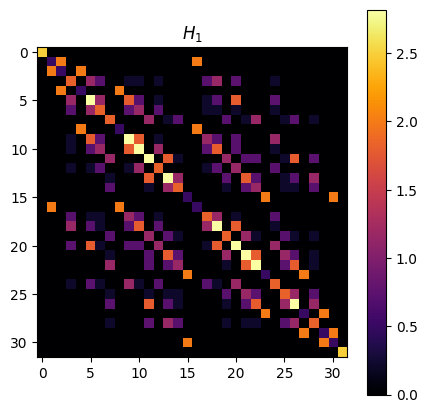

In [94]:
visualize_matrix(dbi.h.matrix, r"$H_1$")

#### Execute more steps of DBI

In [95]:
def n_db_iterations(dbi, nsteps=30, stepsize=0.01, optimize_step=False, d=None):
    """Repeat `nsteps` times the DBI execution."""
    offdiag_norms = [dbi.off_diagonal_norm]
    steps = [0.]
    for _ in range(nsteps):
        if optimize_step:
            stepsize = optimize_stepsize(dbi=dbi, grid_size=100, d=d)
        steps.append(stepsize)
        dbi(step=stepsize, d=d)
        offdiag_norms.append(dbi.off_diagonal_norm)
    return offdiag_norms, steps

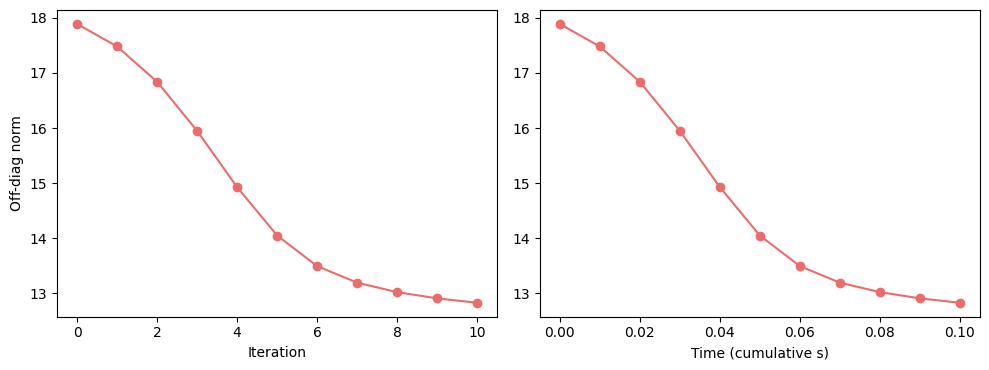

In [96]:
# execute DBI ntimes
dbi = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_type)
offdiag_norms, steps_can = n_db_iterations(dbi=dbi, nsteps=nsteps)

# plot the loss function
plot_loss(losses=[offdiag_norms], steps=[steps_can])

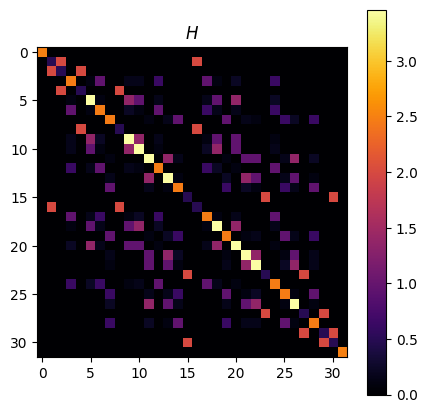

In [97]:
visualize_matrix(dbi.h.matrix, r"$H$")

In [98]:
print(f"Exact ground state energy: {np.min(h0.eigenvalues())}")
print(f"GS Energy according to our diagonalization: {np.real(np.min(dbi.diagonal_h_matrix))}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -3.4610524016659574


#### Optimize the step duration

Let us start by implementing the simpler step optimization ever: a grid search.
This is not optimal, but helps in understanding the importance of hyper-optimizing the DBI. Later in the notebook, we will adopt a smarter strategy to optimize the DBI parameters.

In [99]:
def optimize_stepsize(dbi, d=None, step_range=[-5, 0], grid_size=30):
    """Optimize the stepsize on a grid of values."""
    step_grid = np.logspace(step_range[0], step_range[1], grid_size)

    losses = [dbi.off_diagonal_norm]
    for step in step_grid:
        dbi_copy = deepcopy(dbi)
        dbi_copy(step=step, d=d)
        losses.append(dbi_copy.off_diagonal_norm)

    return step_grid[np.argmin(losses) - 1]

In [100]:
# reset the dbi into the initial configuration
dbi_optimized = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_type)

# execute ntimes
offdiag_opt, steps_can_opt = n_db_iterations(dbi=dbi_optimized, nsteps=nsteps, optimize_step=True)

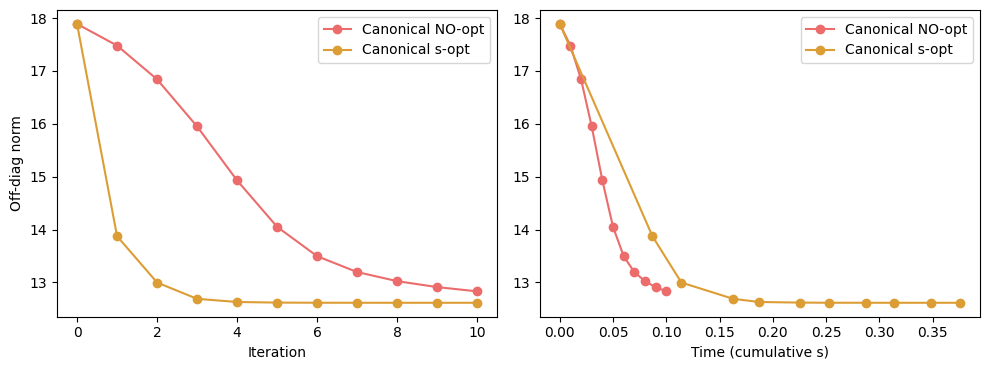

In [101]:
# plot the loss function
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt
    ], 
    steps=[
        steps_can,
        steps_can_opt,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt"]
)

It seems we can converge faster, but with a similar limit plateau. Let's then change generator type. 

#### Let's use an adaptive rotation generator 

Knowing Hamiltonian symmetries ...

In [102]:
comm_gen = DoubleBracketGeneratorType.group_commutator
d_op = np.diag(np.linspace(1,2**nqubits,2**nqubits))
dbi_comm = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=comm_gen)

In [103]:
offdiag_comm, steps_comm = n_db_iterations(dbi=dbi_comm, nsteps=nsteps, optimize_step=True, d=d_op)

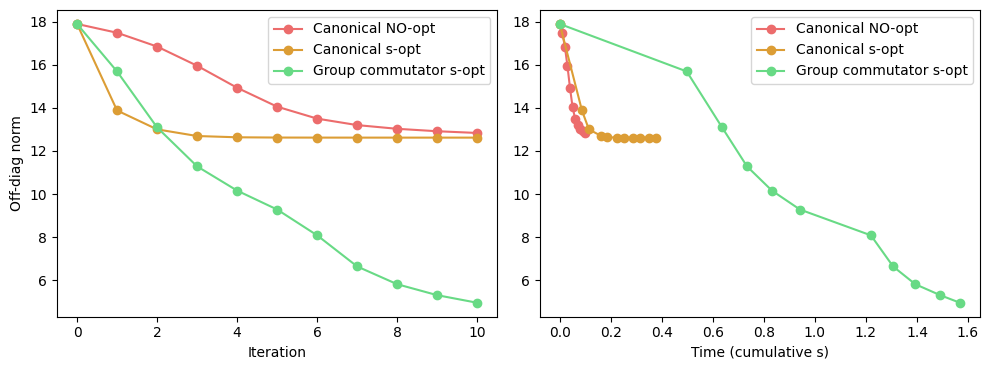

In [104]:
# plot the loss function
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_comm
    ], 
    steps=[
        steps_can,
        steps_can_opt,
        steps_comm,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt", 
        "Group commutator s-opt"
    ]
)

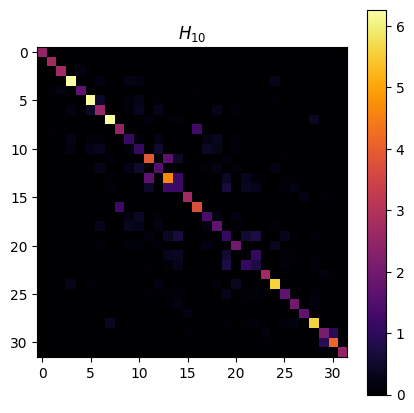

In [105]:
visualize_matrix(dbi_comm.h.matrix, r"$H_{10}$")

In [106]:
print(f"Exact ground state energy: {np.min(h0.eigenvalues())}")
print(f"GS Energy according to our diagonalization: {np.real(np.min(dbi_comm.diagonal_h_matrix))}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -6.260352707135264


#### Parametrize the D operator

In [107]:
from qibo.symbols import Z

def TFIM_d_operator(nqubits, params, print_symbolical=False):
    """
    Parametrize the D operator in form of a classical Transverse Field Ising Model.

    Args:
        nqubits (int): number of qubits;
        params (List[float]): list of coefficients for Z and Z * Z terms in TFIM. 
            It has to be 2 * nqubits long;
    """
    symbolical_d = 0

    for q in range(nqubits):
        symbolical_d += params[::2][q] * Z(q)
        symbolical_d += params[1::2][q] * Z(q) * Z((q + 1) % nqubits)

    if print_symbolical:
        print(symbolical_d)
    
    return hamiltonians.SymbolicHamiltonian(form=symbolical_d).matrix

In [108]:
# random initialization for TFIM
params = np.random.uniform(0., 6., 2 * nqubits)

# setup the D operator
d_op_tfim = TFIM_d_operator(nqubits, params, print_symbolical=True)

1.12721533536245*Z0 + 3.04703649094265*Z0*Z1 + 0.95449494567731*Z1 + 2.70779712097308*Z1*Z2 + 2.61703959839214*Z2 + 3.81165336963818*Z2*Z3 + 4.11779576625741*Z3 + 2.64132771424528*Z3*Z4 + 5.58012636817277*Z4 + 0.997609669624945*Z4*Z0


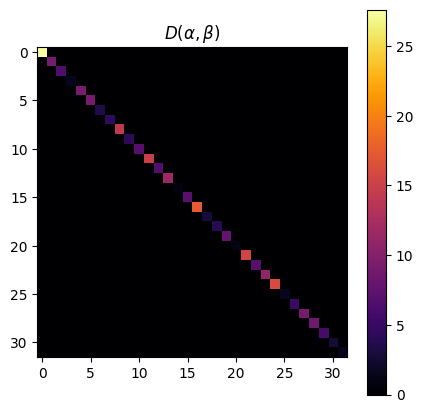

In [109]:
visualize_matrix(d_op_tfim, r"$D(\alpha, \beta)$")

In [110]:
dbi_comm_tfim = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=comm_gen)

In [111]:
offdiag_comm_tfim, steps_comm_tfim = n_db_iterations(dbi=dbi_comm_tfim, nsteps=nsteps, optimize_step=True, d=d_op_tfim)

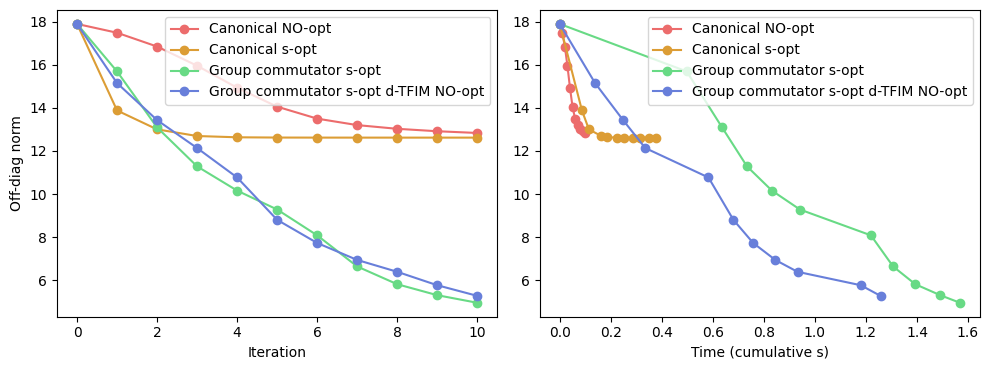

In [112]:
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_comm, 
        offdiag_comm_tfim
    ], 
    steps=[
        steps_can,
        steps_can_opt,
        steps_comm,
        steps_comm_tfim,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt", 
        "Group commutator s-opt",
        "Group commutator s-opt d-TFIM NO-opt",
    ]
)

#### Optimize the D operator

Now that $D$ has been parametrized, we can adopt a variational approach so that we minimize the number of steps required to reach a good diagonalization.

In [113]:
def loss_function_dbi(
    params, 
    dbi
):
    """
    Compute loss function given a DBI configuration, namely given stepsize and the alphas and betas
    which parametrize the D operator.

    Args:
        params (List[float]): variational parameters to be used in the DBI execution.
            The list has to be such that params[0] is the initial stepsize, and then 
            params[1:-1] are (alpha, beta, alpha, beta ...) coefficients of the TFIM parametrization.
        dbi (DoubleBracketIteration): double bracket iteration object.
    """
    dbi_copy = deepcopy(dbi)
    # collect parameters
    d_op = TFIM_d_operator(dbi_copy.h.nqubits, params=params[1:])
    dbi_copy(step=params[0], d=d_op)
    return dbi_copy.off_diagonal_norm

def optimize_DBI(
    dbi, 
    params, 
    s_bounds=(1e-4, 1.), 
    b_bounds=(-9., 9.),
):
    """
    Optimize all hyper-parameters of the DBI, namely the stepsize and the alphas and betas
    which parametrize the D operator.
    """

    lower_bounds = s_bounds[0] + b_bounds[0] * (len(params) - 1)
    upper_bounds = s_bounds[1] + b_bounds[1] * (len(params) - 1)
    bounds = [lower_bounds, upper_bounds]
    result = cma.fmin(
        loss_function_dbi,
        sigma0=0.5,
        x0=params,
        args=(dbi,),
        options={"bounds": bounds, "maxiter": 100},
    )[0]
    return result

In [116]:
dbi_comm_tfim_opt = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=comm_gen)

params = [0.01]
params.extend(np.random.uniform(0., 6., nqubits * 2))

offdiag_tfim_opt = [dbi_comm_tfim_opt.off_diagonal_norm]
steps_comm_tfim_opt = [0.]
for n in range(nsteps):
    print(f"Optimized procedure step {n+1}/{nsteps}")
    best_params = optimize_DBI(dbi=dbi_comm_tfim_opt, params=params)
    steps_comm_tfim_opt.append(np.abs(best_params[0]))
    dbi_comm_tfim_opt(step=best_params[0], d=TFIM_d_operator(nqubits, best_params[1:]))
    offdiag_tfim_opt.append(dbi_comm_tfim_opt.off_diagonal_norm)
    clear_output(wait=True)

Optimized procedure step 10/10
(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 11 (seed=702621, Tue Nov 26 13:26:18 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 2.569687404699534e+00 1.0e+00 4.83e-01  5e-01  5e-01 0:00.2
    2     22 2.592434918379160e+00 1.2e+00 4.45e-01  4e-01  4e-01 0:00.4
    3     33 2.588743968168138e+00 1.2e+00 4.10e-01  4e-01  4e-01 0:00.8
   19    209 2.569910620831601e+00 2.7e+00 3.23e-01  2e-01  4e-01 0:03.9
   41    451 2.556246728180748e+00 6.8e+00 4.25e-01  1e-01  5e-01 0:08.0
   65    715 2.581259369567787e+00 1.2e+01 3.03e-01  5e-02  4e-01 0:13.1
   98   1078 2.454486844138960e+00 4.4e+01 4.19e-01  2e-02  6e-01 0:19.2
  100   1100 2.446132472926048e+00 4.8e+01 3.47e-01  1e-02  5e-01 0:19.5
termination on maxiter=100 (Tue Nov 26 13:26:37 2024)
final/bestever f-value = 2.445521e+00 2.445521e+00 after 1101/1101 evaluations
incumbent solution: [-0.11659004  3.27704607  0.74161097  4.21659535  2.42311498  3.3451

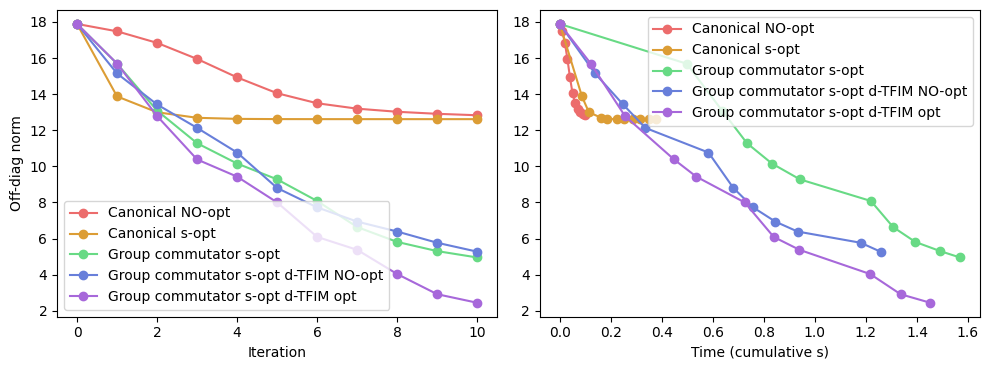

In [117]:
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_comm, 
        offdiag_comm_tfim,
        offdiag_tfim_opt,
    ], 
    steps=[
        steps_can,
        steps_can_opt,
        steps_comm,
        steps_comm_tfim,
        steps_comm_tfim_opt,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt", 
        "Group commutator s-opt",
        "Group commutator s-opt d-TFIM NO-opt",
        "Group commutator s-opt d-TFIM opt",
    ]
)